In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

numpy version:  1.12.1
astropy version:  3.1.dev21950
asdf version:  2.1.0.dev1406
gwcs version:  0.10.dev367
jwst version:  0.9.7a.dev67+gc40578a3 /internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# May need to change the path to "strun"
#!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg nrs1_fs.fits

In [4]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")
esa.remove("esa/Trace_SLIT_B_200_V84600010001P0000000002101_39547_JLAB88.fits")
map_slit_names = {'SLIT_A_1600' : 'S1600A1',
                  'SLIT_A_200_1': 'S200A1',
                  'SLIT_A_200_2': 'S200A2',
                  'SLIT_A_400':   'S400A1',
                  }

In [5]:
im = datamodels.ImageModel('nrs1_fs_assign_wcs.fits')

In [6]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res
    

In [7]:
def plot_stats(reldiffslit, diffslit, mean, dmax, dmin, median, dstd, slice_id, percentage_results):
    title1 = "Slice {}: slit-y diff, normalized to e-7: (sy - slity1) / sliy1\n".format(slice_id)
    title1 += "mean: {}; median: {}\n".format(mean, median)
    title1 += "max: {}; min: {}\n".format(dmax, dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of (sy-slity1) / slity1"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    title3 = "Slice {}: slit-y diff, (sy - slity1)\n".format(slice_id)
    
    fig = plt.figure(figsize=(20, 10))
    title = "Slice {}\n".format(slice_id)
    
    ax1 = plt.subplot(2, 2, 1)
    i1 = ax1.imshow(reldiffslit, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(2, 2, 2)
    i2 = plt.hist(reldiffslit[~np.isnan(diffslit)].flatten(), bins=10)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('Relative diff slit_Y, relative to 0,0')
    plt.ylabel('n')
    ax3 = plt.subplot(2, 2, 3)
    i3 = ax3.imshow(diffslit, aspect='auto')
    plt.colorbar(i3, ax=ax3)
    plt.title(title3)
    ax4 = plt.subplot(2,2,4)
    ln = diffslit.shape[0]//2
    i4 = ax4.plot(diffslit[ln])
    plt.title("line {} of the slit diff, (sy-slity1)[{}]".format(ln, ln))
    plt.subplots_adjust(hspace=.6)

    #fig.tight_layout()

In [8]:
def get_stats(sy, slit1):
        # Use slit locations between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    sy[~in_slit] = np.nan
    nanind = np.isnan(sy)
    notnan = ~nanind
    diffslit = (sy - slit1)
    reldiffslit = (sy - slit1) / slit1
    percentage_results = compute_percentage(diffslit, 1e-7)
    
    # Compute statistics
    mean = np.mean(reldiffslit[notnan])
    median = np.median(reldiffslit[notnan])
    dmax = np.max(reldiffslit[notnan])
    dmin = np.min(reldiffslit[notnan])
    dstd = np.std(reldiffslit[notnan])
    
    return reldiffslit, diffslit, mean, median, dmax, dmin, dstd, percentage_results

In [9]:
def compute_diffs(trace):
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)
    
    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, lam = detector2slit(x1-1, y1-1)
    return sy, slit1, slice_id

sy_1600, slit1_1600, slice_id16 = compute_diffs('esa/Trace_SLIT_A_1600_V84600010001P0000000002101_39547_JLAB88.fits')
reldiffslit16, diffslit16, mean16, med16, dmax16, dmin16, dstd16, percentage_results16 = get_stats(sy_1600, slit1_1600)

sy_2a1, slit1_2a1, slice_id2a1 = compute_diffs('esa/Trace_SLIT_A_200_1_V84600010001P0000000002101_39547_JLAB88.fits')
reldiffslit2a1, diffslit2a1, mean2a1, med2a1, dmax2a1, dmin2a1, dstd2a1, percentage_results2a1 = get_stats(sy_2a1, slit1_2a1)
    
    
sy_2a2, slit1_2a2, slice_id2a2 = compute_diffs('esa/Trace_SLIT_A_200_2_V84600010001P0000000002101_39547_JLAB88.fits')
reldiffslit2a2, diffslit2a2, mean2a2, med2a2, dmax2a2, dmin2a2, dstd2a2, percentage_results2a2 = get_stats(sy_2a2, slit1_2a2)
        
sy_4a1, slit1_4a1, slice_id4a1 = compute_diffs('esa/Trace_SLIT_A_400_V84600010001P0000000002101_39547_JLAB88.fits')
reldiffslit4a1, diffslit4a1, mean4a1, med4a1, dmax4a1, dmin4a1, dstd4a1, percentage_results4a1 = get_stats(sy_4a1, slit1_4a1)
    
        

The following plots show for each slice:

- upper left plot: Difference (sy_pipe - SLITY1) / SLITY1
- upper right plot: historgram of the difference in "upper left" plot
- lower left plot: difference (sy_pipe - SLITY1)
- lower right plot: Plot of row 25 of the plot in lower left

I suspect the spatial pattern in lower left is due to the choice of interpolation points when going from GWA to SLIT_Y positions. At least the beating pattern shown in the lower right corner is consistent with using different interpolation points.

Also I think the upper left plot shows that the metrics chosen for SLITY comparison should be revised. If SLITY1 positions in the Trace files are computed with single precision, it's not reasonable to expect the differences to be of the order of e-14.



***Slice S1600A1***

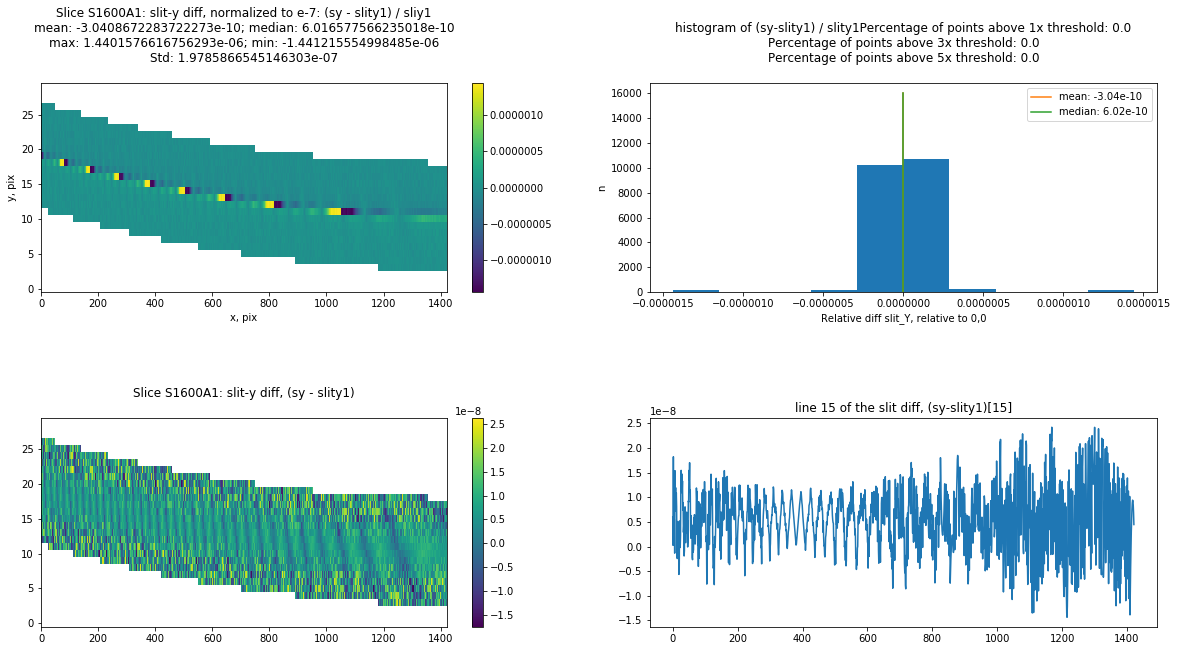

In [10]:
    plot_stats(reldiffslit16, diffslit16, mean16, dmax16, dmin16, med16, dstd16, slice_id16, percentage_results16)

***Slice S200A1***

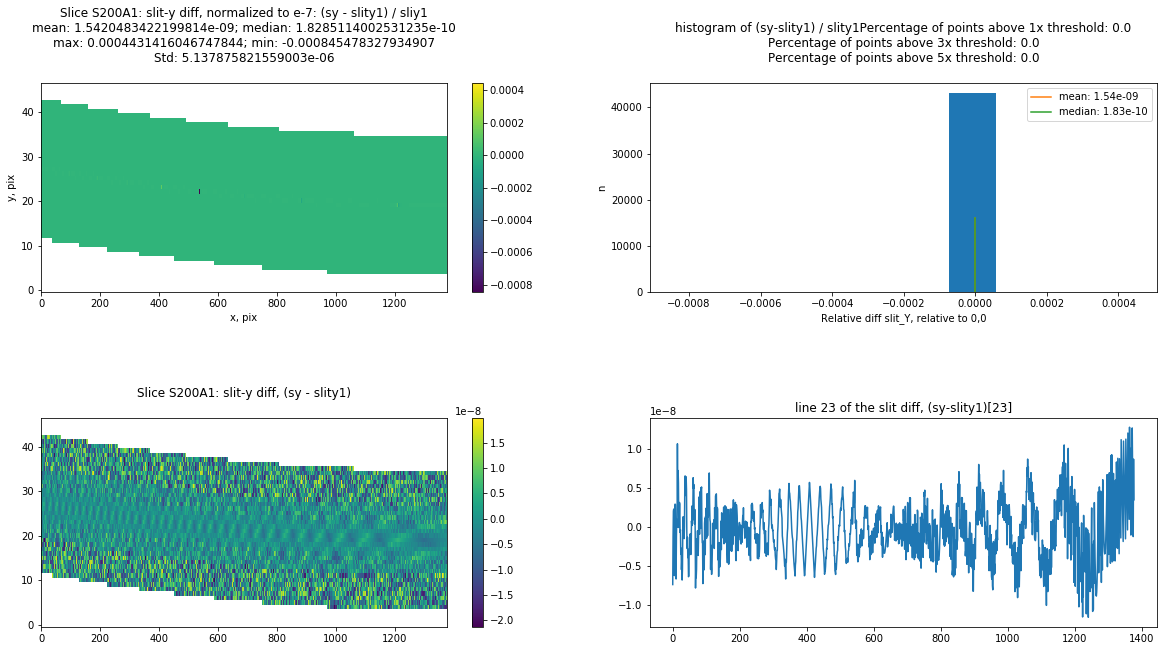

In [11]:
plot_stats(reldiffslit2a1, diffslit2a1, mean2a1, dmax2a1, dmin2a1, med2a1, dstd2a1, slice_id2a1, percentage_results2a1)

***Slice S200A2***

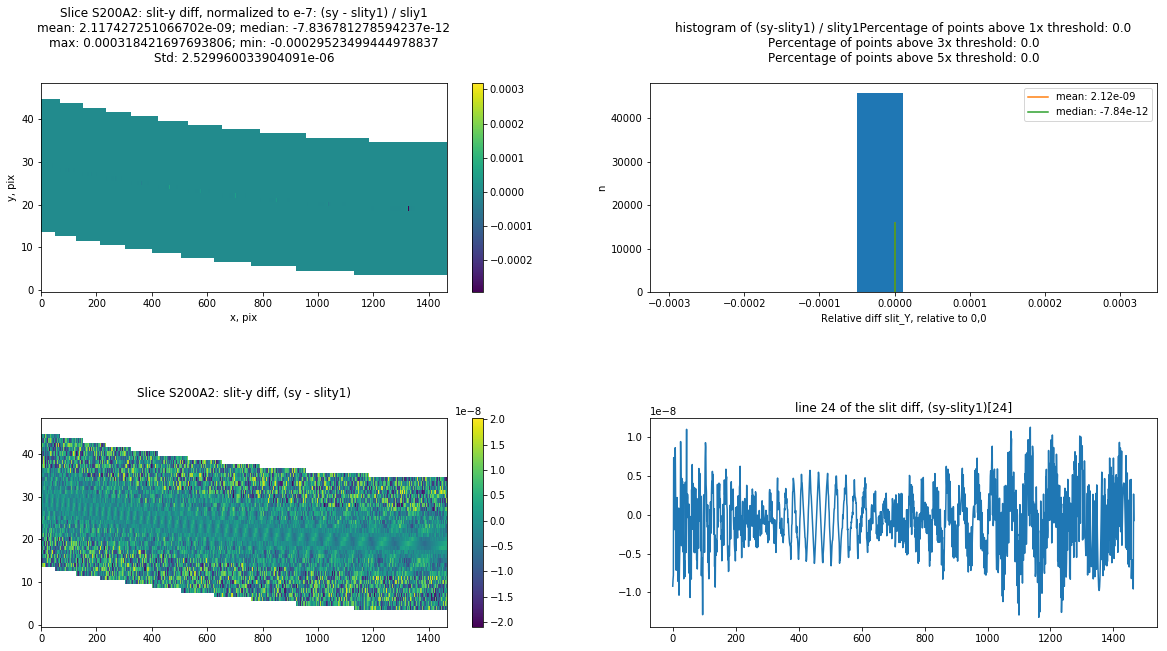

In [12]:
plot_stats(reldiffslit2a2, diffslit2a2, mean2a2, dmax2a2, dmin2a2, med2a2, dstd2a2, slice_id2a2, percentage_results2a2)

***Slice S400A1***

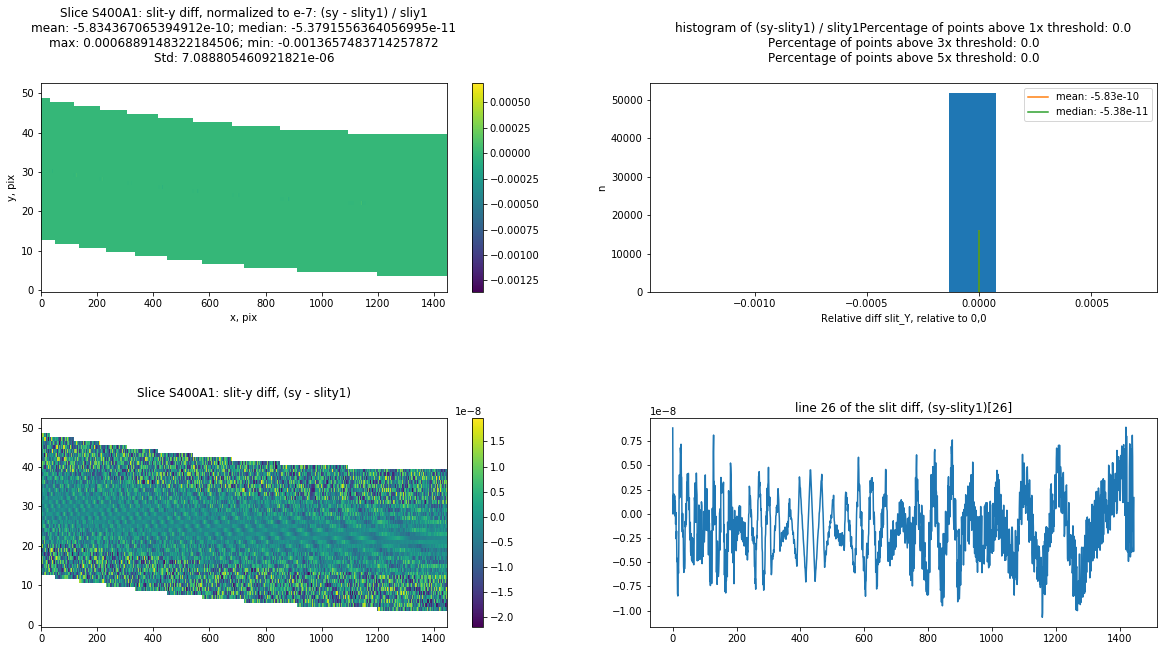

In [13]:
plot_stats(reldiffslit4a1, diffslit4a1, mean4a1, dmax4a1, dmin4a1, med4a1, dstd4a1, slice_id4a1, percentage_results4a1)

### MSA_Y position

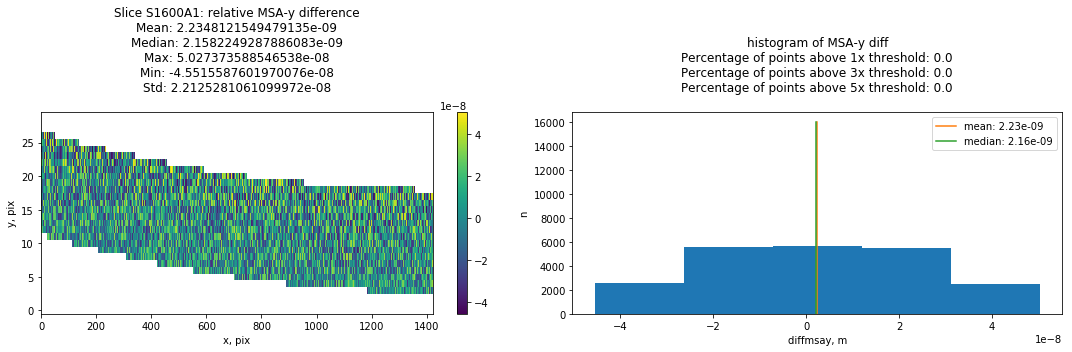

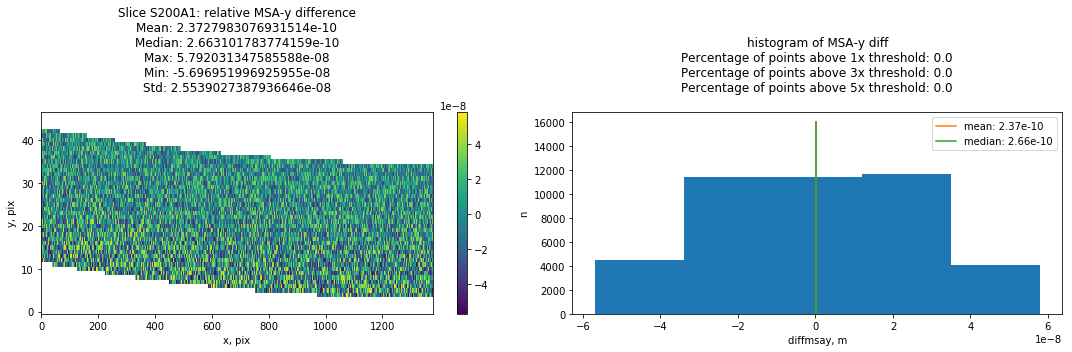

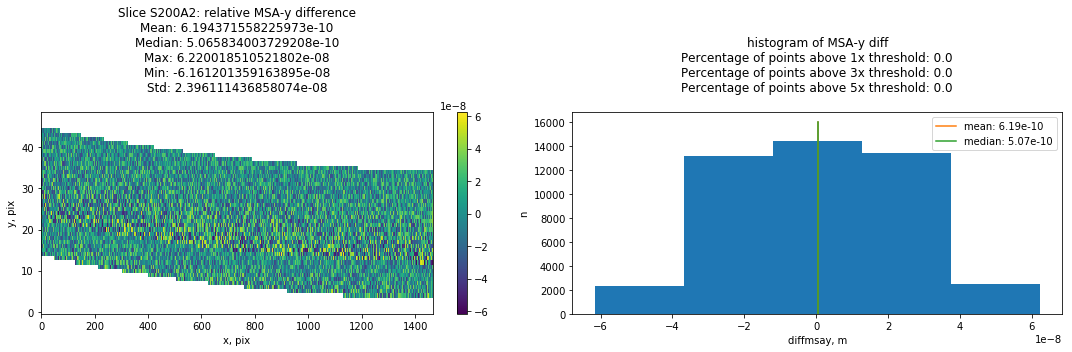

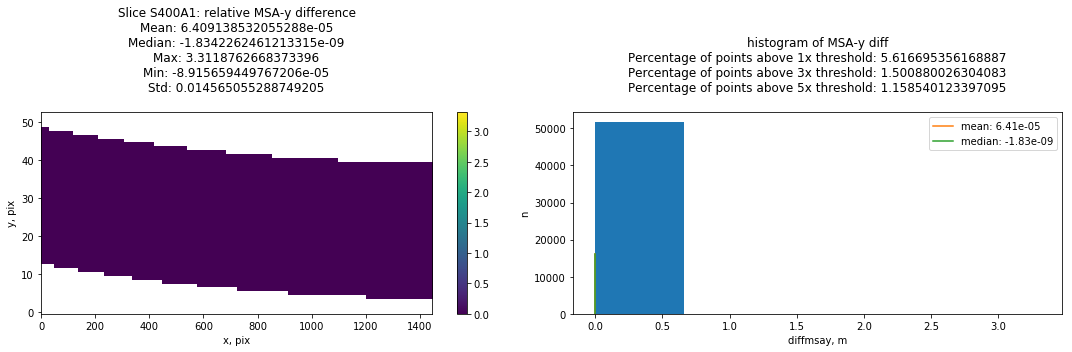

In [14]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msay1 = tr['MSAY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in MSA positions
    detector2slit = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2slit(x1-1, y1-1)
    
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    my[~in_slit] = np.nan
    nanind = np.isnan(my)
    notnan = ~nanind
    
    diffmsay = (my - msay1) / msay1
    percentage_results = compute_percentage(diffmsay, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsay[notnan])
    median = np.median(diffmsay[notnan])
    dmax = np.max(diffmsay[notnan])
    dmin = np.min(diffmsay[notnan])
    dstd = np.std(diffmsay[notnan])

    title1 = "Slice {}: relative MSA-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-y diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsay, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsay[~np.isnan(diffmsay)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsay, m')
    plt.ylabel('n')
    fig.tight_layout()

### Compute MSA_Y position using as inputs the SLIT_Y positions from the Trace files

There isn't much difference with the previous plots where pipeline SLITY positions were used as inputs.
The issue with S400A1 is still visible.

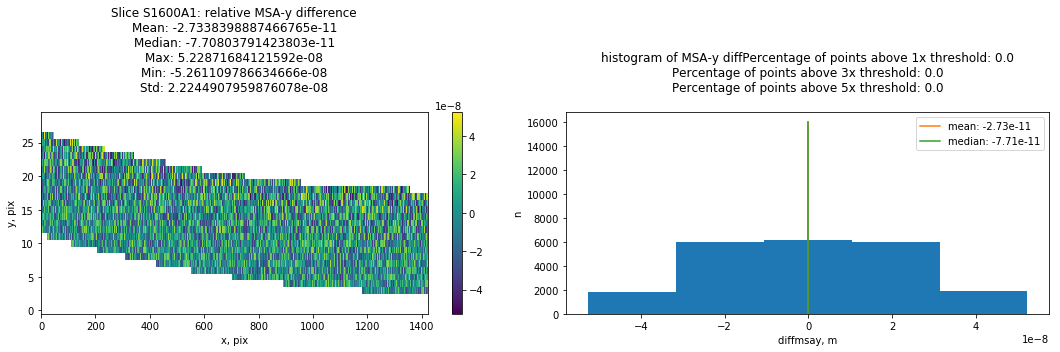

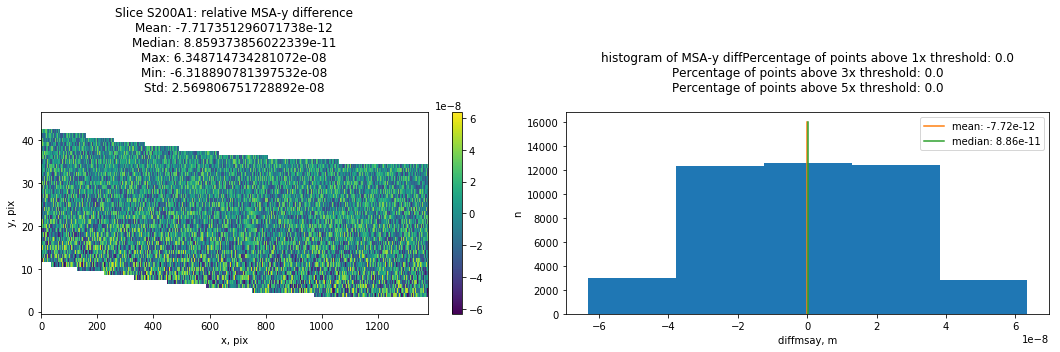

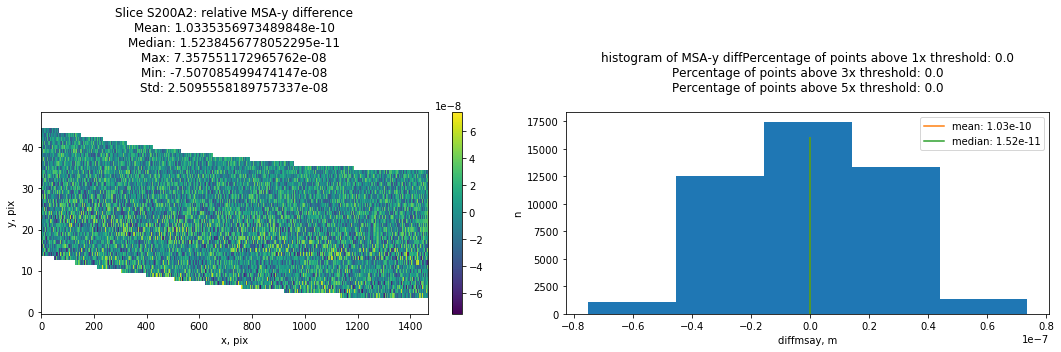

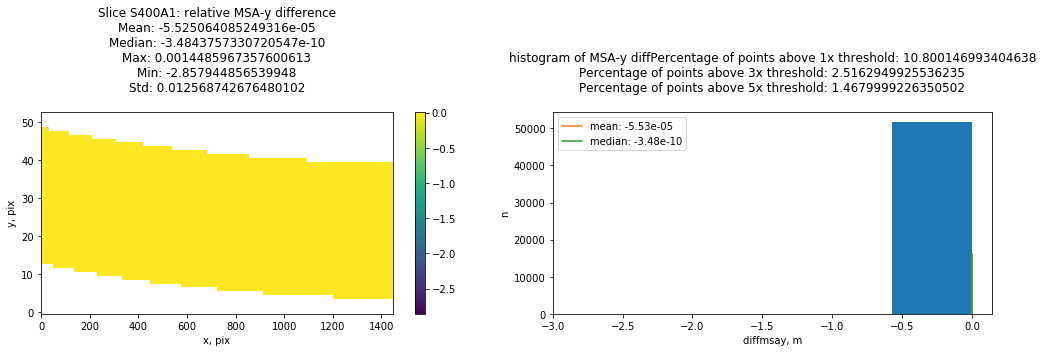

In [15]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msay1 = tr['MSAY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in MSA positions
    slit2msa = wcs_slice.get_transform("slit_frame", "msa_frame")
    sx = np.zeros(msay1.shape)
    
    mx, my, lam = slit2msa(sx, slit1, lam1)
    
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    my[~in_slit] = np.nan
    nanind = np.isnan(my)
    notnan = ~nanind
    
    diffmsay = (my - msay1) / msay1
    percentage_results = compute_percentage(diffmsay, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsay[notnan])
    median = np.median(diffmsay[notnan])
    dmax = np.max(diffmsay[notnan])
    dmin = np.min(diffmsay[notnan])
    dstd = np.std(diffmsay[notnan])
    
    title1 = "Slice {}: relative MSA-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-y diff"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsay, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsay[~np.isnan(diffmsay)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsay, m')
    plt.ylabel('n')
    fig.tight_layout()

### A look at  Slit S400A1

I have no explanation for the large differences. The pipeline uses the same MSA reference file for all slits and the same code to cmopute slit to MSA positions.

In [16]:
tr = fits.open('esa/Trace_SLIT_A_400_V84600010001P0000000002101_39547_JLAB88.fits')
lam1 = tr['LAMBDA1'].data
slit1 = tr['SLITY1'].data
msay1 = tr['MSAY1'].data
pyw = wcs.WCS(tr['LAMBDA1'].header)
slice_id = map_slit_names[tr[0].header['SLITID']]
tr.close()

# Create x, y indices using the Trace WCS
y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
x1, y1 = pyw.all_pix2world(x, y, 0)

# Get the WCS for this particular slice
wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)


# Compute the difference in MSA positions
slit2msa = wcs_slice.get_transform("slit_frame", "msa_frame")
sx = np.zeros(msay1.shape)

mx, my, lam = slit2msa(sx, slit1, lam1)

in_slit = np.logical_and(slit1<.5, slit1>-.5)
my[~in_slit] = np.nan
nanind = np.isnan(my)
notnan = ~nanind

diffmsa = (my - msay1)

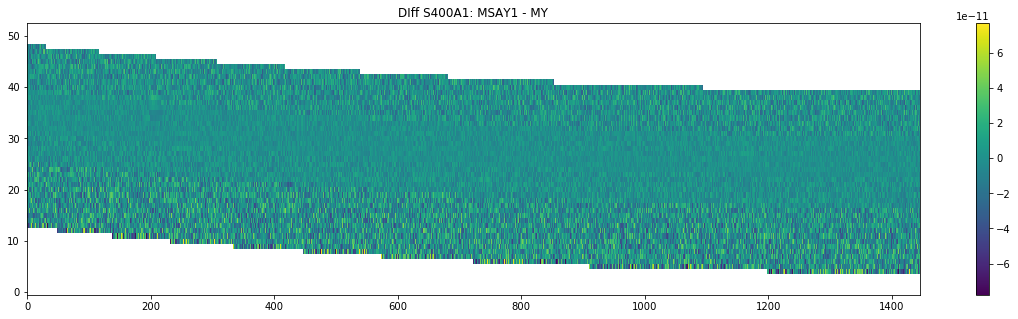

In [17]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(diffmsa, aspect='auto')
plt.colorbar()
plt.title("DIff S400A1: MSAY1 - MY")